In [4]:
!pip install optuna

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split,KFold
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, TensorDataset, random_split
from sklearn.metrics import roc_auc_score, r2_score, mean_squared_error,mean_absolute_error
import math
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from transformers import T5Tokenizer,AutoTokenizer,BertTokenizer,AutoModel
import re
from sklearn.model_selection import train_test_split
from torch.utils.data import Subset
import os

In [ ]:
# df=pd.read_csv('/content/drive/MyDrive/lstm_data/data.csv')

In [3]:
torch.manual_seed(3407)

In [4]:
df=pd.read_csv('/kaggle/input/peptide/data.csv')

In [5]:
df.shape

(134281, 4)

In [6]:
df['mhc'].value_counts()

mhc
QEFFIASGAAVDAIMWLFLECYDLQRATYHVGFT    10412
QEFFIASGAAVDAIMWGYFELYVIDRQTVHVGFT     6325
QEFFIASGAAVDAIMEVHFDYYDLQKATYHVGFT     6317
QEFFIASGAAVDAIMESSFDYFDFDRATYHVGFT     6045
QEFFIASGAAVDAIMESSYDYFDLQKRNYHVVFT     5352
                                      ...  
QEFFIASGAAVDAIMESGFDYYDFDRLTYHVVFT        3
QEFFIASGAAVDAIMQDYFHGYDFDRATYHVGFT        2
QEFFIASGAAVDAIMEVHFDYYSLQRETYHVVFT        2
QEFFIASGAAVDAIMESSFEYYDLQRATYHVGFT        1
QEFFIASGAAVDAIMWPRFDHFDIQAATYHVVFT        1
Name: count, Length: 75, dtype: int64

In [7]:
tokenizer = AutoTokenizer.from_pretrained("facebook/esm2_t6_8M_UR50D",do_lower_case=False)

tokenizer_config.json:   0%|          | 0.00/95.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/93.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

In [8]:
pep_sequences = [" ".join(list(re.sub(r"[UZOB]", "X", data))) for data in df['pep']]
mhc_sequences = [" ".join(list(re.sub(r"[UZOB]", "X", data))) for data in df['mhc']]

In [9]:
pep_ids = tokenizer(pep_sequences, add_special_tokens=True, padding="longest")
mhc_ids = tokenizer(mhc_sequences, add_special_tokens=True, padding="longest")

In [10]:
tokenizer.get_vocab()

{'<cls>': 0,
 '<pad>': 1,
 '<eos>': 2,
 '<unk>': 3,
 'L': 4,
 'A': 5,
 'G': 6,
 'V': 7,
 'S': 8,
 'E': 9,
 'R': 10,
 'T': 11,
 'I': 12,
 'D': 13,
 'P': 14,
 'K': 15,
 'Q': 16,
 'N': 17,
 'F': 18,
 'Y': 19,
 'M': 20,
 'H': 21,
 'W': 22,
 'C': 23,
 'X': 24,
 'B': 25,
 'U': 26,
 'Z': 27,
 'O': 28,
 '.': 29,
 '-': 30,
 '<null_1>': 31,
 '<mask>': 32}

In [11]:
vocab_size = len(tokenizer.get_vocab())
print(vocab_size)

33


In [12]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [13]:
pep_input_ids = torch.tensor(pep_ids['input_ids']).to(device)
pep_attention_mask = torch.tensor(pep_ids['attention_mask']).to(device)
mhc_input_ids = torch.tensor(mhc_ids['input_ids']).to(device)
mhc_attention_mask = torch.tensor(mhc_ids['attention_mask']).to(device)

In [14]:
scores = torch.tensor(df['logic'].values,dtype=torch.float32).to(device)

In [15]:
extra_pad = pep_input_ids.size(1)-mhc_input_ids.size(1)
extra_pad

3

In [16]:
mhc_input_ids = F.pad(mhc_input_ids, (0, extra_pad), value = 1)
mhc_attention_mask = F.pad(mhc_attention_mask, (0, extra_pad), value = 0)

In [17]:
y = scores

In [18]:
X = torch.stack((pep_input_ids,mhc_input_ids,pep_attention_mask,mhc_attention_mask),dim=1)
y = torch.tensor(df['logic'].values,dtype=torch.float32).to(device)

In [25]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)

In [26]:
X_train,X_val,y_train,y_val = train_test_split(X_train,y_train,test_size=0.2,random_state=42)

In [27]:
train_dataset = TensorDataset(X_train[: ,0],X_train[:,1],X_train[:,2],X_train[:,3], y_train)
val_dataset = TensorDataset(X_val[:,0],X_val[:,1],X_val[:,2],X_val[:,3], y_val)
test_dataset = TensorDataset(X_test[:,0],X_test[:,1],X_test[:,2],X_test[:,3],y_test)

In [28]:
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
val_loader = DataLoader(val_dataset,batch_size=256,shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False)

In [ ]:
# class LSTMEncoder(nn.Module):
#     def __init__(self, input_dim, hidden_dim, num_layers, dropout=0.1):
#         super().__init__()
#         self.lstm = nn.LSTM(
#             input_size=input_dim,
#             hidden_size=hidden_dim,
#             num_layers=num_layers,
#             batch_first=True,
#             dropout=dropout if num_layers > 1 else 0
#         )

#     def forward(self, x):
#         x = x.unsqueeze(1) #Now x.shape is batch_size, 1, input_dim
#         output, (hidden, cell) = self.lstm(x)
#         return hidden[-1]  #Shape: batch_size, hidden_dim


# class CrossAttentionLayer(nn.Module):
#     def __init__(self, embed_dim, num_heads, dropout=0.1):
#         super().__init__()
#         self.multihead_attn = nn.MultiheadAttention(embed_dim, num_heads, dropout=dropout, batch_first=True)
#         self.norm1 = nn.LayerNorm(embed_dim)
#         self.ffn = nn.Sequential(
#             nn.Linear(embed_dim, 4*embed_dim),
#             nn.ReLU(),
#             nn.Dropout(dropout),
#             nn.Linear(4*embed_dim, embed_dim)
#         )
#         self.norm2 = nn.LayerNorm(embed_dim)

#     def forward(self, query, key, value):
#         attn_output, attn_weights = self.multihead_attn(query, key, value)
#         attn_output = self.norm1(attn_output + query)
#         ffn_output = self.ffn(attn_output)
#         output = self.norm2(ffn_output + attn_output)

#         return output, attn_weights


# class Model(nn.Module):
#     def __init__(self, input_dim, hidden_dim, num_heads, num_layers,dropout=0.1):
#         super().__init__()
#         self.encoder_pep = LSTMEncoder(input_dim, hidden_dim, num_layers, dropout)
#         self.encoder_mhc = LSTMEncoder(input_dim, hidden_dim, num_layers, dropout)
#         self.cross_attention = CrossAttentionLayer(hidden_dim, num_heads, dropout)
#         self.last_layer=nn.Sequential(
#             nn.Linear(hidden_dim, 128),
#             nn.ReLU(),
#             nn.Dropout(dropout),
#             nn.Linear(128, 64),
#             nn.ReLU(),
#             nn.Dropout(dropout),
#             nn.Linear(64, 1)
#         )

#     def forward(self, pep_cls, mhc_cls):
#         pep_refined = self.encoder_pep(pep_cls)
#         mhc_refined = self.encoder_mhc(mhc_cls)
#         cross_output, attn_weights = self.cross_attention(
#             pep_refined.unsqueeze(1), mhc_refined.unsqueeze(1), mhc_refined.unsqueeze(1)
#         )
#         cross_output = cross_output.squeeze(1)
#         x = self.last_layer(cross_output)

#         return x, attn_weights


In [19]:
import torch
import torch.nn as nn
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

class LSTMEncoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, dropout=0.1):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=input_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0
        )

    def forward(self, x, lengths=None):
        if lengths is not None:
            # Sort sequences by length in descending order
            sorted_lengths, sorted_indices = torch.sort(lengths, descending=True)
            x_sorted = x[sorted_indices]

            # Pack padded sequence
            packed_x = pack_padded_sequence(x_sorted, sorted_lengths.cpu(), batch_first=True, enforce_sorted=True)
            packed_output, (hidden, cell) = self.lstm(packed_x)

            # Unpack and reorder to original sequence order
            output, _ = pad_packed_sequence(packed_output, batch_first=True)
            unsorted_indices = sorted_indices.argsort()
            output = output[unsorted_indices]
        else:
            output, (hidden, cell) = self.lstm(x)

        return output  # (batch_size, seq_len, hidden_dim)

class CrossAttentionLayer(nn.Module):
    def __init__(self, embed_dim, num_heads, dropout=0.1):
        super().__init__()
        self.multihead_attn = nn.MultiheadAttention(
            embed_dim, num_heads, dropout=dropout, batch_first=True
        )
        self.norm1 = nn.LayerNorm(embed_dim)
        self.ffn = nn.Sequential(
            nn.Linear(embed_dim, 4 * embed_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(4 * embed_dim, embed_dim)
        )
        self.norm2 = nn.LayerNorm(embed_dim)

    def forward(self, query, key, value, key_padding_mask=None):
        attn_output, attn_weights = self.multihead_attn(
            query=query,
            key=key,
            value=value,
            key_padding_mask=key_padding_mask
        )
        attn_output = self.norm1(attn_output + query)
        ffn_output = self.ffn(attn_output)
        output = self.norm2(ffn_output + attn_output)
        return output, attn_weights

class Model(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_heads, num_layers,
                 vocab_size, dropout=0.1):
        super().__init__()
        self.embed_pep = nn.Sequential(
            nn.Embedding(vocab_size, input_dim),
            nn.LayerNorm(input_dim))

        self.embed_mhc = nn.Sequential(
            nn.Embedding(vocab_size, input_dim),
            nn.LayerNorm(input_dim)
        )

        self.encoder_pep = LSTMEncoder(input_dim, hidden_dim, num_layers, dropout)
        self.encoder_mhc = LSTMEncoder(input_dim, hidden_dim, num_layers, dropout)

        self.cross_attention = CrossAttentionLayer(hidden_dim, num_heads, dropout)

        self.last_layer = nn.Sequential(
            nn.Linear(hidden_dim, 128),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(128, 64),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(64, 1)
        )

    def forward(self, pep_cls, mhc_cls):
        # Embed sequences
        pep_embedded = self.embed_pep(pep_cls)  # (batch_size, pep_len, input_dim)
        mhc_embedded = self.embed_mhc(mhc_cls)  # (batch_size, mhc_len, input_dim)

        # Calculate sequence lengths (assuming 0 is padding index)
        pep_lengths = (pep_cls != 1).sum(dim=1)
        mhc_lengths = (mhc_cls != 1).sum(dim=1)

        # Encode sequences
        pep_refined = self.encoder_pep(pep_embedded, pep_lengths)  # (batch, pep_len, hidden_dim)
        mhc_refined = self.encoder_mhc(mhc_embedded, mhc_lengths)  # (batch, mhc_len, hidden_dim)

        # Create padding mask for MHC sequences
        mhc_padding_mask = (mhc_cls == 1)  # (batch_size, mhc_len)
        mhc_padding_mask = mhc_padding_mask[:, :mhc_refined.shape[1]]

        # Apply cross-attention
        cross_output, attn_weights = self.cross_attention(
            query=pep_refined,
            key=mhc_refined,
            value=mhc_refined,
            key_padding_mask=mhc_padding_mask
        )  # (batch_size, pep_len, hidden_dim)

        # Aggregate cross-attention output
        cross_aggregated = cross_output.mean(dim=1)  # (batch_size, hidden_dim)

        # Final prediction
        x = self.last_layer(cross_aggregated)

        return x, attn_weights

In [43]:
import optuna
from optuna.trial import TrialState
import torch
from torch import nn
from torch.optim import AdamW
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import numpy as np
def objective(trial):
    input_dim = trial.suggest_categorical("model_dim",[64,128,256,512])
    num_heads = trial.suggest_categorical("num_heads", [4, 8])
    num_layers = trial.suggest_categorical("num_layers", [2, 3, 4])
    dropout = trial.suggest_categorical("dropout", [0.1, 0.2, 0.3])
    lr = trial.suggest_categorical("learning_rate", [1e-4, 1e-3])
    weight_decay = trial.suggest_categorical("weight_decay", [1e-2, 1e-3, 1e-4, 1e-5])

    model = Model(input_dim, input_dim, num_heads, num_layers,vocab_size, dropout=dropout).to(device)

    criterion = nn.HuberLoss()
    optimizer = AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)

    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=128, shuffle=False)

    for epoch in range(5):
        model.train()
        train_loss = 0
        for pep_ids, mhc_ids, pep_mask, mhc_mask, scores in train_loader:
            pep_ids, mhc_ids, pep_mask, mhc_mask, scores = (
                pep_ids.to(device), mhc_ids.to(device),
                pep_mask.to(device), mhc_mask.to(device),
                scores.to(device)
            )

            optimizer.zero_grad()
            outputs, _ = model(pep_ids, mhc_ids)
            loss = criterion(outputs.squeeze(), scores)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        train_loss /= len(train_loader)

        model.eval()
        val_loss = 0
        total_val_preds = []
        total_val_labels = []
        with torch.no_grad():
            for pep_ids, mhc_ids, pep_mask, mhc_mask, scores in val_loader:
                pep_ids, mhc_ids, pep_mask, mhc_mask, scores = (
                    pep_ids.to(device), mhc_ids.to(device),
                    pep_mask.to(device), mhc_mask.to(device),
                    scores.to(device)
                )

                outputs, _ = model(pep_ids, mhc_ids)
                loss = criterion(outputs.squeeze(), scores)
                val_loss += loss.item()
                total_val_preds.append(outputs.cpu())
                total_val_labels.append(scores.cpu())

        val_loss /= len(val_loader)

        total_val_preds = torch.cat(total_val_preds, dim=0).numpy().flatten()
        total_val_labels = torch.cat(total_val_labels, dim=0).numpy().flatten()
        val_r2 = r2_score(total_val_labels, total_val_preds)
        val_mse = mean_squared_error(total_val_labels, total_val_preds)
        val_rmse = np.sqrt(val_mse)
        val_mae = mean_absolute_error(total_val_labels, total_val_preds)

        print(f"Trial Results: Val Loss: {val_loss:.4f}, Val R^2: {val_r2:.4f}, Val MSE: {val_mse:.4f}, Val RMSE: {val_rmse:.4f}, Val MAE: {val_mae:.4f}")

    return val_loss

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=15)

print("Best trial:")
trial = study.best_trial

print(f"  Val Loss: {trial.value:.4f}")
print(f"  Hyperparameters: {trial.params}")

best_hyperparams = trial.params


[I 2025-03-05 19:45:36,875] A new study created in memory with name: no-name-58929d29-892e-4ddb-ad31-4de28fb316b7


Trial Results: Val Loss: 0.0208, Val R^2: 0.3931, Val MSE: 0.0416, Val RMSE: 0.2040, Val MAE: 0.1612
Trial Results: Val Loss: 0.0181, Val R^2: 0.4715, Val MSE: 0.0362, Val RMSE: 0.1904, Val MAE: 0.1502
Trial Results: Val Loss: 0.0181, Val R^2: 0.4729, Val MSE: 0.0361, Val RMSE: 0.1901, Val MAE: 0.1499
Trial Results: Val Loss: 0.0161, Val R^2: 0.5306, Val MSE: 0.0322, Val RMSE: 0.1794, Val MAE: 0.1395


[I 2025-03-05 19:47:34,480] Trial 0 finished with value: 0.0155915350132134 and parameters: {'model_dim': 256, 'num_heads': 8, 'num_layers': 2, 'dropout': 0.2, 'learning_rate': 0.001, 'weight_decay': 1e-05}. Best is trial 0 with value: 0.0155915350132134.


Trial Results: Val Loss: 0.0156, Val R^2: 0.5453, Val MSE: 0.0312, Val RMSE: 0.1766, Val MAE: 0.1380
Trial Results: Val Loss: 0.0233, Val R^2: 0.3206, Val MSE: 0.0466, Val RMSE: 0.2158, Val MAE: 0.1759
Trial Results: Val Loss: 0.0208, Val R^2: 0.3942, Val MSE: 0.0415, Val RMSE: 0.2038, Val MAE: 0.1632
Trial Results: Val Loss: 0.0197, Val R^2: 0.4245, Val MSE: 0.0395, Val RMSE: 0.1987, Val MAE: 0.1577
Trial Results: Val Loss: 0.0192, Val R^2: 0.4406, Val MSE: 0.0384, Val RMSE: 0.1959, Val MAE: 0.1558


[I 2025-03-05 19:48:36,903] Trial 1 finished with value: 0.018991900979363846 and parameters: {'model_dim': 128, 'num_heads': 8, 'num_layers': 2, 'dropout': 0.2, 'learning_rate': 0.0001, 'weight_decay': 0.0001}. Best is trial 0 with value: 0.0155915350132134.


Trial Results: Val Loss: 0.0190, Val R^2: 0.4462, Val MSE: 0.0380, Val RMSE: 0.1949, Val MAE: 0.1538
Trial Results: Val Loss: 0.0215, Val R^2: 0.3732, Val MSE: 0.0430, Val RMSE: 0.2073, Val MAE: 0.1666
Trial Results: Val Loss: 0.0198, Val R^2: 0.4230, Val MSE: 0.0396, Val RMSE: 0.1989, Val MAE: 0.1586
Trial Results: Val Loss: 0.0189, Val R^2: 0.4497, Val MSE: 0.0377, Val RMSE: 0.1943, Val MAE: 0.1550
Trial Results: Val Loss: 0.0179, Val R^2: 0.4771, Val MSE: 0.0359, Val RMSE: 0.1894, Val MAE: 0.1494


[I 2025-03-05 19:57:55,547] Trial 2 finished with value: 0.01736723582282485 and parameters: {'model_dim': 512, 'num_heads': 8, 'num_layers': 4, 'dropout': 0.2, 'learning_rate': 0.0001, 'weight_decay': 0.0001}. Best is trial 0 with value: 0.0155915350132134.


Trial Results: Val Loss: 0.0174, Val R^2: 0.4936, Val MSE: 0.0347, Val RMSE: 0.1864, Val MAE: 0.1463
Trial Results: Val Loss: 0.0212, Val R^2: 0.3815, Val MSE: 0.0424, Val RMSE: 0.2059, Val MAE: 0.1661
Trial Results: Val Loss: 0.0187, Val R^2: 0.4551, Val MSE: 0.0374, Val RMSE: 0.1933, Val MAE: 0.1537
Trial Results: Val Loss: 0.0194, Val R^2: 0.4356, Val MSE: 0.0387, Val RMSE: 0.1967, Val MAE: 0.1534
Trial Results: Val Loss: 0.0170, Val R^2: 0.5031, Val MSE: 0.0341, Val RMSE: 0.1846, Val MAE: 0.1436


[I 2025-03-05 20:03:19,386] Trial 3 finished with value: 0.01612185392462249 and parameters: {'model_dim': 512, 'num_heads': 4, 'num_layers': 2, 'dropout': 0.1, 'learning_rate': 0.001, 'weight_decay': 0.0001}. Best is trial 0 with value: 0.0155915350132134.


Trial Results: Val Loss: 0.0161, Val R^2: 0.5298, Val MSE: 0.0322, Val RMSE: 0.1796, Val MAE: 0.1400
Trial Results: Val Loss: 0.0212, Val R^2: 0.3806, Val MSE: 0.0425, Val RMSE: 0.2061, Val MAE: 0.1657
Trial Results: Val Loss: 0.0197, Val R^2: 0.4257, Val MSE: 0.0394, Val RMSE: 0.1985, Val MAE: 0.1581
Trial Results: Val Loss: 0.0183, Val R^2: 0.4667, Val MSE: 0.0366, Val RMSE: 0.1912, Val MAE: 0.1504
Trial Results: Val Loss: 0.0183, Val R^2: 0.4657, Val MSE: 0.0366, Val RMSE: 0.1914, Val MAE: 0.1517


[I 2025-03-05 20:05:16,777] Trial 4 finished with value: 0.01738296426455712 and parameters: {'model_dim': 256, 'num_heads': 8, 'num_layers': 2, 'dropout': 0.1, 'learning_rate': 0.0001, 'weight_decay': 0.0001}. Best is trial 0 with value: 0.0155915350132134.


Trial Results: Val Loss: 0.0174, Val R^2: 0.4931, Val MSE: 0.0348, Val RMSE: 0.1865, Val MAE: 0.1471
Trial Results: Val Loss: 0.0229, Val R^2: 0.3336, Val MSE: 0.0457, Val RMSE: 0.2138, Val MAE: 0.1731
Trial Results: Val Loss: 0.0213, Val R^2: 0.3789, Val MSE: 0.0426, Val RMSE: 0.2064, Val MAE: 0.1644
Trial Results: Val Loss: 0.0201, Val R^2: 0.4133, Val MSE: 0.0402, Val RMSE: 0.2006, Val MAE: 0.1603
Trial Results: Val Loss: 0.0194, Val R^2: 0.4348, Val MSE: 0.0388, Val RMSE: 0.1969, Val MAE: 0.1577


[I 2025-03-05 20:08:15,941] Trial 5 finished with value: 0.018588071500527718 and parameters: {'model_dim': 256, 'num_heads': 8, 'num_layers': 4, 'dropout': 0.3, 'learning_rate': 0.0001, 'weight_decay': 0.01}. Best is trial 0 with value: 0.0155915350132134.


Trial Results: Val Loss: 0.0186, Val R^2: 0.4580, Val MSE: 0.0372, Val RMSE: 0.1928, Val MAE: 0.1522
Trial Results: Val Loss: 0.0343, Val R^2: -0.0009, Val MSE: 0.0686, Val RMSE: 0.2620, Val MAE: 0.2190
Trial Results: Val Loss: 0.0343, Val R^2: -0.0006, Val MSE: 0.0686, Val RMSE: 0.2620, Val MAE: 0.2190
Trial Results: Val Loss: 0.0343, Val R^2: 0.0007, Val MSE: 0.0685, Val RMSE: 0.2618, Val MAE: 0.2190
Trial Results: Val Loss: 0.0342, Val R^2: 0.0025, Val MSE: 0.0684, Val RMSE: 0.2616, Val MAE: 0.2188


[I 2025-03-05 20:17:28,969] Trial 6 finished with value: 0.0342505369335413 and parameters: {'model_dim': 512, 'num_heads': 4, 'num_layers': 4, 'dropout': 0.2, 'learning_rate': 0.001, 'weight_decay': 0.01}. Best is trial 0 with value: 0.0155915350132134.


Trial Results: Val Loss: 0.0343, Val R^2: 0.0012, Val MSE: 0.0685, Val RMSE: 0.2617, Val MAE: 0.2186
Trial Results: Val Loss: 0.0224, Val R^2: 0.3456, Val MSE: 0.0449, Val RMSE: 0.2119, Val MAE: 0.1709
Trial Results: Val Loss: 0.0209, Val R^2: 0.3899, Val MSE: 0.0418, Val RMSE: 0.2045, Val MAE: 0.1636
Trial Results: Val Loss: 0.0195, Val R^2: 0.4305, Val MSE: 0.0391, Val RMSE: 0.1976, Val MAE: 0.1574
Trial Results: Val Loss: 0.0188, Val R^2: 0.4507, Val MSE: 0.0377, Val RMSE: 0.1941, Val MAE: 0.1541


[I 2025-03-05 20:20:26,512] Trial 7 finished with value: 0.01849006967330795 and parameters: {'model_dim': 256, 'num_heads': 4, 'num_layers': 4, 'dropout': 0.2, 'learning_rate': 0.0001, 'weight_decay': 1e-05}. Best is trial 0 with value: 0.0155915350132134.


Trial Results: Val Loss: 0.0185, Val R^2: 0.4608, Val MSE: 0.0370, Val RMSE: 0.1923, Val MAE: 0.1520
Trial Results: Val Loss: 0.0223, Val R^2: 0.3499, Val MSE: 0.0446, Val RMSE: 0.2112, Val MAE: 0.1693
Trial Results: Val Loss: 0.0200, Val R^2: 0.4179, Val MSE: 0.0399, Val RMSE: 0.1998, Val MAE: 0.1594
Trial Results: Val Loss: 0.0193, Val R^2: 0.4360, Val MSE: 0.0387, Val RMSE: 0.1967, Val MAE: 0.1539
Trial Results: Val Loss: 0.0184, Val R^2: 0.4622, Val MSE: 0.0369, Val RMSE: 0.1920, Val MAE: 0.1537


[I 2025-03-05 20:23:24,262] Trial 8 finished with value: 0.01919006586207875 and parameters: {'model_dim': 256, 'num_heads': 4, 'num_layers': 4, 'dropout': 0.3, 'learning_rate': 0.001, 'weight_decay': 1e-05}. Best is trial 0 with value: 0.0155915350132134.


Trial Results: Val Loss: 0.0192, Val R^2: 0.4404, Val MSE: 0.0384, Val RMSE: 0.1959, Val MAE: 0.1547
Trial Results: Val Loss: 0.0227, Val R^2: 0.3386, Val MSE: 0.0454, Val RMSE: 0.2130, Val MAE: 0.1731
Trial Results: Val Loss: 0.0201, Val R^2: 0.4130, Val MSE: 0.0403, Val RMSE: 0.2006, Val MAE: 0.1603
Trial Results: Val Loss: 0.0195, Val R^2: 0.4326, Val MSE: 0.0389, Val RMSE: 0.1973, Val MAE: 0.1557
Trial Results: Val Loss: 0.0189, Val R^2: 0.4481, Val MSE: 0.0379, Val RMSE: 0.1946, Val MAE: 0.1544


[I 2025-03-05 20:25:52,872] Trial 9 finished with value: 0.01831765615359126 and parameters: {'model_dim': 256, 'num_heads': 8, 'num_layers': 3, 'dropout': 0.3, 'learning_rate': 0.0001, 'weight_decay': 0.001}. Best is trial 0 with value: 0.0155915350132134.


Trial Results: Val Loss: 0.0183, Val R^2: 0.4658, Val MSE: 0.0366, Val RMSE: 0.1914, Val MAE: 0.1497
Trial Results: Val Loss: 0.0225, Val R^2: 0.3430, Val MSE: 0.0451, Val RMSE: 0.2123, Val MAE: 0.1715
Trial Results: Val Loss: 0.0200, Val R^2: 0.4173, Val MSE: 0.0400, Val RMSE: 0.1999, Val MAE: 0.1574
Trial Results: Val Loss: 0.0187, Val R^2: 0.4542, Val MSE: 0.0374, Val RMSE: 0.1935, Val MAE: 0.1537
Trial Results: Val Loss: 0.0182, Val R^2: 0.4686, Val MSE: 0.0364, Val RMSE: 0.1909, Val MAE: 0.1497


[I 2025-03-05 20:27:03,550] Trial 10 finished with value: 0.017642055233452646 and parameters: {'model_dim': 64, 'num_heads': 8, 'num_layers': 3, 'dropout': 0.2, 'learning_rate': 0.001, 'weight_decay': 1e-05}. Best is trial 0 with value: 0.0155915350132134.


Trial Results: Val Loss: 0.0176, Val R^2: 0.4855, Val MSE: 0.0353, Val RMSE: 0.1878, Val MAE: 0.1472
Trial Results: Val Loss: 0.0220, Val R^2: 0.3590, Val MSE: 0.0440, Val RMSE: 0.2097, Val MAE: 0.1701
Trial Results: Val Loss: 0.0202, Val R^2: 0.4111, Val MSE: 0.0404, Val RMSE: 0.2010, Val MAE: 0.1587
Trial Results: Val Loss: 0.0180, Val R^2: 0.4736, Val MSE: 0.0361, Val RMSE: 0.1900, Val MAE: 0.1498
Trial Results: Val Loss: 0.0173, Val R^2: 0.4950, Val MSE: 0.0346, Val RMSE: 0.1861, Val MAE: 0.1457


[I 2025-03-05 20:32:28,622] Trial 11 finished with value: 0.01654495019465685 and parameters: {'model_dim': 512, 'num_heads': 4, 'num_layers': 2, 'dropout': 0.1, 'learning_rate': 0.001, 'weight_decay': 0.001}. Best is trial 0 with value: 0.0155915350132134.


Trial Results: Val Loss: 0.0165, Val R^2: 0.5175, Val MSE: 0.0331, Val RMSE: 0.1819, Val MAE: 0.1416
Trial Results: Val Loss: 0.0206, Val R^2: 0.4004, Val MSE: 0.0411, Val RMSE: 0.2028, Val MAE: 0.1611
Trial Results: Val Loss: 0.0192, Val R^2: 0.4410, Val MSE: 0.0383, Val RMSE: 0.1958, Val MAE: 0.1543
Trial Results: Val Loss: 0.0182, Val R^2: 0.4686, Val MSE: 0.0364, Val RMSE: 0.1909, Val MAE: 0.1504
Trial Results: Val Loss: 0.0186, Val R^2: 0.4566, Val MSE: 0.0373, Val RMSE: 0.1931, Val MAE: 0.1524


[I 2025-03-05 20:33:30,590] Trial 12 finished with value: 0.017063991959384156 and parameters: {'model_dim': 64, 'num_heads': 4, 'num_layers': 2, 'dropout': 0.1, 'learning_rate': 0.001, 'weight_decay': 0.0001}. Best is trial 0 with value: 0.0155915350132134.


Trial Results: Val Loss: 0.0171, Val R^2: 0.5024, Val MSE: 0.0341, Val RMSE: 0.1847, Val MAE: 0.1455
Trial Results: Val Loss: 0.0204, Val R^2: 0.4056, Val MSE: 0.0408, Val RMSE: 0.2019, Val MAE: 0.1614
Trial Results: Val Loss: 0.0186, Val R^2: 0.4581, Val MSE: 0.0372, Val RMSE: 0.1928, Val MAE: 0.1537
Trial Results: Val Loss: 0.0173, Val R^2: 0.4948, Val MSE: 0.0346, Val RMSE: 0.1861, Val MAE: 0.1474
Trial Results: Val Loss: 0.0174, Val R^2: 0.4913, Val MSE: 0.0349, Val RMSE: 0.1868, Val MAE: 0.1472


[I 2025-03-05 20:34:32,324] Trial 13 finished with value: 0.0162661933517527 and parameters: {'model_dim': 128, 'num_heads': 4, 'num_layers': 2, 'dropout': 0.1, 'learning_rate': 0.001, 'weight_decay': 1e-05}. Best is trial 0 with value: 0.0155915350132134.


Trial Results: Val Loss: 0.0163, Val R^2: 0.5257, Val MSE: 0.0325, Val RMSE: 0.1804, Val MAE: 0.1415
Trial Results: Val Loss: 0.0249, Val R^2: 0.2729, Val MSE: 0.0499, Val RMSE: 0.2233, Val MAE: 0.1796
Trial Results: Val Loss: 0.0204, Val R^2: 0.4054, Val MSE: 0.0408, Val RMSE: 0.2019, Val MAE: 0.1615
Trial Results: Val Loss: 0.0182, Val R^2: 0.4699, Val MSE: 0.0364, Val RMSE: 0.1907, Val MAE: 0.1513
Trial Results: Val Loss: 0.0173, Val R^2: 0.4969, Val MSE: 0.0345, Val RMSE: 0.1858, Val MAE: 0.1461


[I 2025-03-05 20:39:57,477] Trial 14 finished with value: 0.01694791556690775 and parameters: {'model_dim': 512, 'num_heads': 8, 'num_layers': 2, 'dropout': 0.1, 'learning_rate': 0.001, 'weight_decay': 1e-05}. Best is trial 0 with value: 0.0155915350132134.


Trial Results: Val Loss: 0.0169, Val R^2: 0.5058, Val MSE: 0.0339, Val RMSE: 0.1841, Val MAE: 0.1454
Best trial:
  Val Loss: 0.0156
  Hyperparameters: {'model_dim': 256, 'num_heads': 8, 'num_layers': 2, 'dropout': 0.2, 'learning_rate': 0.001, 'weight_decay': 1e-05}


In [55]:
device="cuda" if torch.cuda.is_available() else "cpu"
vocab_size= 33
hidden_dim = input_dim = 256
num_heads = 8
num_layers = 2
dropout = 0.2
model = Model(input_dim, hidden_dim, num_heads, num_layers,vocab_size, dropout=dropout).to(device)
criterion = nn.HuberLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001,weight_decay=1e-5)
epochs = 200

In [56]:
patience = 2
best_val_loss = float('inf')
patience_counter = 0
save_path = '/kaggle/working/lstmreg.pth'
train_losses = []
val_losses = []
val_r2_list = []
train_mse_list = []
val_mse_list = []
train_rmse_list = []
val_rmse_list = []
train_mae_list = []
val_mae_list = []
train_r2_list = []

for epoch in range(epochs):
    # Train loop
    model.train()
    train_loss = 0
    total_train_preds = []
    total_train_labels = []

    for pep_ids, mhc_ids, pep_mask, mhc_mask, scores in train_loader:
        pep_ids, mhc_ids, pep_mask, mhc_mask, scores = (
            pep_ids.to(device), mhc_ids.to(device),
            pep_mask.to(device), mhc_mask.to(device),
            scores.to(device)
        )

        optimizer.zero_grad()
        outputs,_ = model(pep_ids, mhc_ids)
        loss = criterion(outputs.squeeze(), scores)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        total_train_preds.append(outputs.detach().cpu())
        total_train_labels.append(scores.detach().cpu())

    train_loss /= len(train_loader)
    train_losses.append(train_loss)

    total_train_preds = torch.cat(total_train_preds, dim=0).numpy().flatten()
    total_train_labels = torch.cat(total_train_labels, dim=0).numpy().flatten()
    train_r2 = r2_score(total_train_labels, total_train_preds)
    train_mse = mean_squared_error(total_train_labels, total_train_preds)
    train_rmse = np.sqrt(train_mse)
    train_mae = mean_absolute_error(total_train_labels, total_train_preds)

    train_r2_list.append(train_r2)
    train_mse_list.append(train_mse)
    train_rmse_list.append(train_rmse)
    train_mae_list.append(train_mae)

    print(f"Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Train R^2: {train_r2:.4f}, MSE: {train_mse:.4f}, RMSE: {train_rmse:.4f}, MAE: {train_mae:.4f}")

    # Validation loop
    model.eval()
    val_loss = 0
    total_val_preds = []
    total_val_labels = []

    with torch.no_grad():
        for pep_ids, mhc_ids, pep_mask, mhc_mask, scores in val_loader:
            pep_ids, mhc_ids, pep_mask, mhc_mask, scores = (
                pep_ids.to(device), mhc_ids.to(device),
                pep_mask.to(device), mhc_mask.to(device),
                scores.to(device)
            )
            outputs,_ = model(pep_ids, mhc_ids)
            loss = criterion(outputs.squeeze(), scores)
            val_loss += loss.item()
            total_val_preds.append(outputs.cpu())
            total_val_labels.append(scores.cpu())

    val_loss /= len(val_loader)
    val_losses.append(val_loss)

    total_val_preds = torch.cat(total_val_preds, dim=0).numpy().flatten()
    total_val_labels = torch.cat(total_val_labels, dim=0).numpy().flatten()
    val_r2 = r2_score(total_val_labels, total_val_preds)
    val_mse = mean_squared_error(total_val_labels, total_val_preds)
    val_rmse = np.sqrt(val_mse)
    val_mae = mean_absolute_error(total_val_labels, total_val_preds)

    val_r2_list.append(val_r2)
    val_mse_list.append(val_mse)
    val_rmse_list.append(val_rmse)
    val_mae_list.append(val_mae)

    print(f"Epoch {epoch+1}, Val Loss: {val_loss:.4f}, Val R^2: {val_r2:.4f}, MSE: {val_mse:.4f}, RMSE: {val_rmse:.4f}, MAE: {val_mae:.4f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        torch.save(model.state_dict(), save_path)
        print(f"Best model saved with Val Loss: {best_val_loss:.4f}")
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch+1}. Best Val Loss: {best_val_loss:.4f}")
            break

Epoch 1, Train Loss: 0.0260, Train R^2: 0.2393, MSE: 0.0520, RMSE: 0.2281, MAE: 0.1844
Epoch 1, Val Loss: 0.0216, Val R^2: 0.3710, MSE: 0.0431, RMSE: 0.2077, MAE: 0.1671
Best model saved with Val Loss: 0.0216
Epoch 2, Train Loss: 0.0207, Train R^2: 0.3957, MSE: 0.0413, RMSE: 0.2033, MAE: 0.1620
Epoch 2, Val Loss: 0.0192, Val R^2: 0.4406, MSE: 0.0384, RMSE: 0.1959, MAE: 0.1542
Best model saved with Val Loss: 0.0192
Epoch 3, Train Loss: 0.0184, Train R^2: 0.4621, MSE: 0.0368, RMSE: 0.1918, MAE: 0.1516
Epoch 3, Val Loss: 0.0183, Val R^2: 0.4653, MSE: 0.0367, RMSE: 0.1915, MAE: 0.1511
Best model saved with Val Loss: 0.0183
Epoch 4, Train Loss: 0.0168, Train R^2: 0.5090, MSE: 0.0336, RMSE: 0.1832, MAE: 0.1440
Epoch 4, Val Loss: 0.0168, Val R^2: 0.5105, MSE: 0.0336, RMSE: 0.1832, MAE: 0.1434
Best model saved with Val Loss: 0.0168
Epoch 5, Train Loss: 0.0155, Train R^2: 0.5460, MSE: 0.0310, RMSE: 0.1762, MAE: 0.1380
Epoch 5, Val Loss: 0.0160, Val R^2: 0.5325, MSE: 0.0321, RMSE: 0.1790, MAE: 0

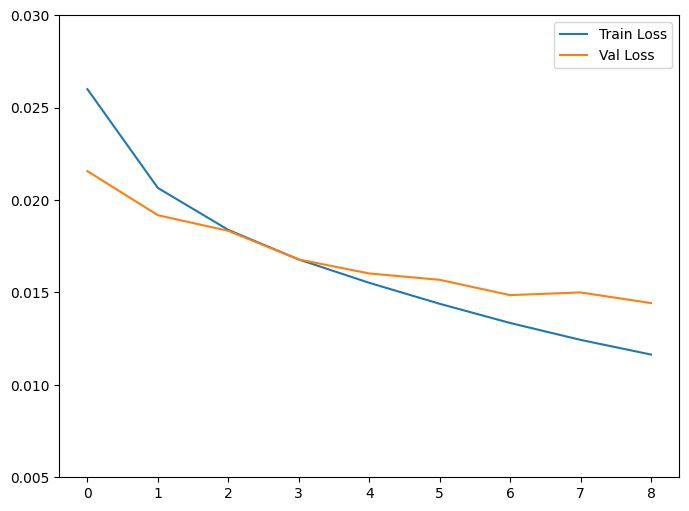

In [75]:
plt.figure(figsize=(8,6))
plt.plot(train_losses[:9],label="Train Loss")
plt.plot(val_losses[:9],label="Val Loss")
plt.yticks(np.arange(0.005, max(max(train_losses), max(val_losses)) + 0.005, 0.005))
plt.legend()
plt.show()

In [76]:
save_path="/kaggle/working/lstmreg.pth"
state_dict = torch.load(save_path)
model.load_state_dict(state_dict)

<ipython-input-76-cab547d0ac30>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(save_path)


<All keys matched successfully>

Test Loss: 0.0140
Test R^2: 0.5923
Test MSE: 0.0280
Test MAE: 0.1279
Test RMSE: 0.1674


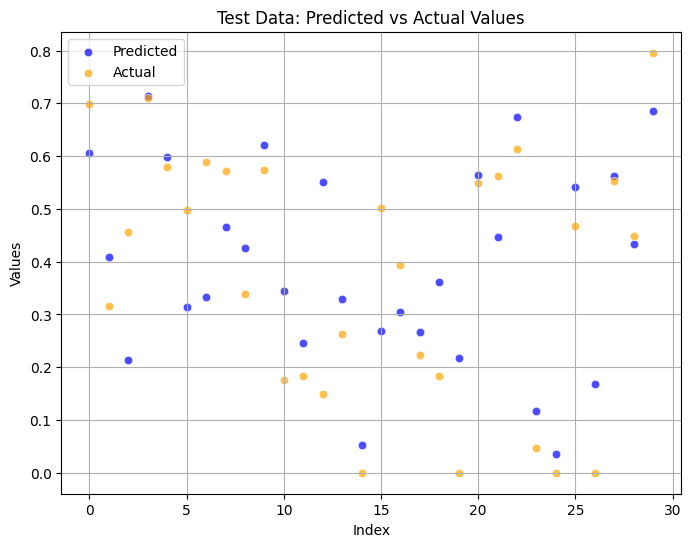

In [77]:
model.eval()
test_loss = 0
test_scores = []
test_predictions = []

with torch.no_grad():
    for pep_ids, mhc_ids, pep_mask, mhc_mask, scores in test_loader:
        pep_ids, mhc_ids, pep_mask, mhc_mask, scores = (
            pep_ids.to(device), mhc_ids.to(device),
            pep_mask.to(device), mhc_mask.to(device),
            scores.to(device)
        )
        outputs, _ = model(pep_ids, mhc_ids)
        test_predictions.extend(outputs.cpu().numpy().flatten())

        test_scores.extend(scores.cpu().numpy().flatten())
        loss = criterion(outputs.squeeze(), scores)
        test_loss += loss.item()

test_loss /= len(test_loader)

test_scores = np.array(test_scores)
test_predictions = np.array(test_predictions)
test_mse = mean_squared_error(test_scores, test_predictions)
test_mae = mean_absolute_error(test_scores, test_predictions)
test_rmse = np.sqrt(test_mse)


test_r2 = r2_score(test_scores, test_predictions)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test R^2: {test_r2:.4f}")
print(f"Test MSE: {test_mse:.4f}")
print(f"Test MAE: {test_mae:.4f}")
print(f"Test RMSE: {test_rmse:.4f}")

val_data = pd.DataFrame({
    'Index': np.arange(len(test_predictions[:30])),
    'Predicted': test_predictions[:30],
    'Actual': test_scores[:30]
})
plt.figure(figsize=(8, 6))
sns.scatterplot(data=val_data, x='Index', y='Predicted', color='blue', label='Predicted', alpha=0.7)
sns.scatterplot(data=val_data, x='Index', y='Actual', color='orange', label='Actual', alpha=0.7)

plt.xlabel("Index")
plt.ylabel("Values")
plt.title("Test Data: Predicted vs Actual Values")
plt.legend()
plt.grid(True)
plt.show()

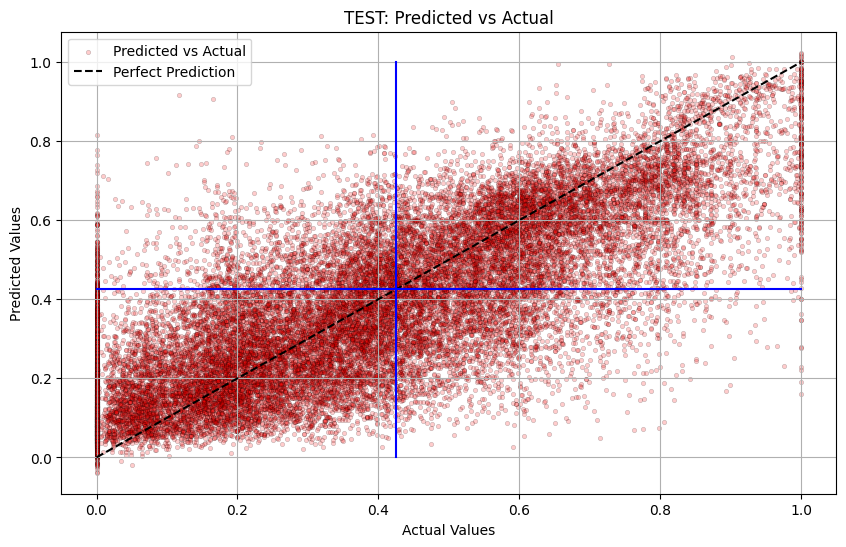

In [84]:
test_data = pd.DataFrame({
    'Predicted':test_predictions,
    'Actual': test_scores
})
plt.figure(figsize=(10, 6))
sns.scatterplot(x=test_data['Actual'], y=test_data['Predicted'], color='red', s=10, alpha=0.2, edgecolor='black', linewidth=0.5, label='Predicted vs Actual')
plt.plot([min(test_data['Actual']), max(test_data['Actual'])], [min(test_data['Actual']), max(test_data['Actual'])], color='black', linestyle='--', label='Perfect Prediction')
plt.plot([0.4256,0.4256],[0,1],color='blue',)
plt.plot([0,1],[0.4256,0.4256],color='blue')
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("TEST: Predicted vs Actual")
plt.legend()
plt.grid(True)
plt.show()

In [80]:
threshold = 0.4256


Statistics for Test Scores:
        Test Scores
count  26857.000000
mean       0.380822
std        0.262244
min        0.000000
25%        0.168865
50%        0.369153
75%        0.578369
max        1.000000

Statistics for Test Predictions:
       Test Predictions
count      26857.000000
mean           0.375833
std            0.215192
min           -0.038785
25%            0.194616
50%            0.353465
75%            0.538029
max            1.023772

Statistics for Residuals:
          Residuals
count  26857.000000
mean       0.004989
std        0.167371
min       -0.815698
25%       -0.095022
50%       -0.003289
75%        0.104776
max        0.840462


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


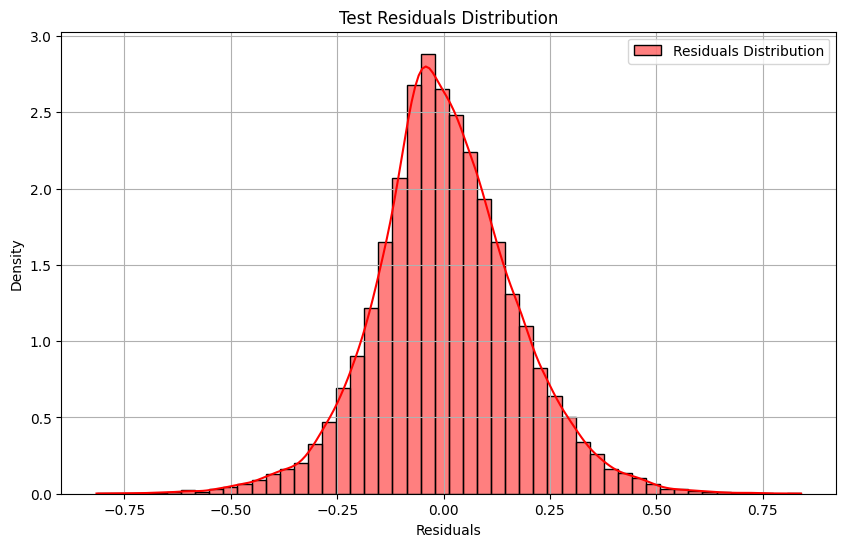

In [81]:
residuals = test_scores - test_predictions

# Create DataFrames
df_scores = pd.DataFrame(test_scores, columns=['Test Scores'])
df_preds = pd.DataFrame(test_predictions, columns=['Test Predictions'])
df_residuals = pd.DataFrame(residuals, columns=['Residuals'])

# Print statistics using .describe()
print("\nStatistics for Test Scores:")
print(df_scores.describe())

print("\nStatistics for Test Predictions:")
print(df_preds.describe())

print("\nStatistics for Residuals:")
print(df_residuals.describe())

# Plot residuals histogram
plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True, bins=50, stat='density', label='Residuals Distribution', color='red')
plt.xlabel('Residuals')
plt.ylabel('Density')
plt.title('Test Residuals Distribution')
plt.legend()
plt.grid(True)
plt.show()


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


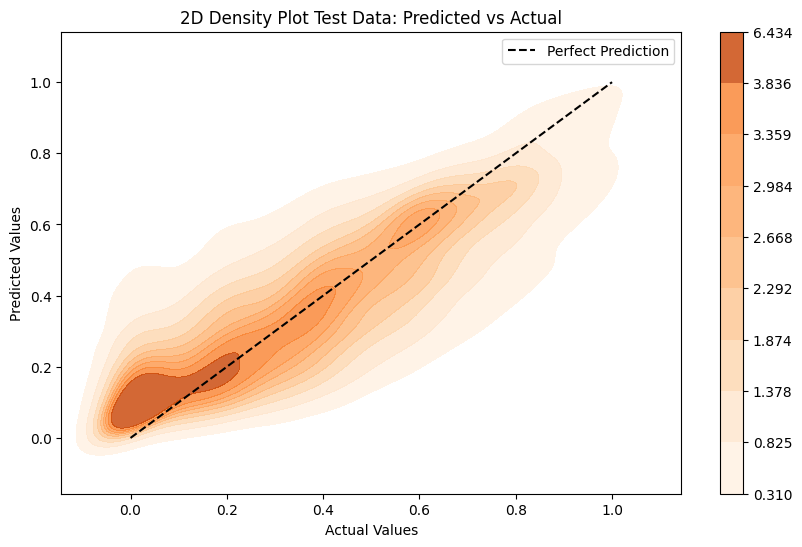

In [82]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming test_predictions and test_scores are already defined
test_data = pd.DataFrame({
    'Predicted': test_predictions,
    'Actual': test_scores
})

# Create the 2D density plot
plt.figure(figsize=(10, 6))
kde = sns.kdeplot(
    x=test_data['Actual'],
    y=test_data['Predicted'],
    cmap="Oranges",  # Adjust the colormap
    fill=True,     # Fill the contours
    levels=10,     # Number of levels for contouring
    alpha=0.8,     # Transparency of the filled regions
    cbar=True      # Add the color bar
)

# Add threshold lines
plt.plot([min(test_data['Actual']), max(test_data['Actual'])], [min(test_data['Actual']), max(test_data['Actual'])], color='black', linestyle='--', label='Perfect Prediction')

# Add labels, title, and legend
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("2D Density Plot Test Data: Predicted vs Actual")
plt.legend()

# Show the plot
plt.show()


# KFOLD

In [20]:
from torch.utils.data import Subset
from sklearn.model_selection import KFold
import os



k_folds = 5
kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)
batch_size = 256
epochs = 200
patience = 3
save_dir = '/kaggle/working/'


In [21]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)

In [22]:
train_dataset = TensorDataset(X_train[: ,0],X_train[:,1],X_train[:,2],X_train[:,3], y_train)
test_dataset = TensorDataset(X_test[: ,0],X_test[:,1],X_test[:,2],X_test[:,3], y_test)

In [23]:
batch_size=256

In [26]:
device="cuda" if torch.cuda.is_available() else "cpu"
vocab_size= 33
hidden_dim = input_dim = 256
num_heads = 8
num_layers = 2
dropout = 0.2
epochs = 200

In [27]:
patience = 2

In [29]:
for fold, (train_idx, val_idx) in enumerate(kf.split(range(len(train_dataset)))):
    print(f"Starting Fold {fold + 1}/{k_folds}")

    train_subset = Subset(train_dataset, train_idx)
    val_subset = Subset(train_dataset, val_idx)


    train_loader = DataLoader(train_subset, batch_size=256, shuffle=True)
    val_loader = DataLoader(val_subset, batch_size=256, shuffle=False)


    model = Model(input_dim, hidden_dim, num_heads, num_layers,vocab_size, dropout=dropout).to(device)
    criterion = nn.HuberLoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=0.001,weight_decay=1e-05)

    best_val_loss = float("inf")
    patience_counter = 0
    #train loop
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        total_train_preds, total_train_labels = [], []

        for pep_ids, mhc_ids, pep_mask, mhc_mask, scores in train_loader:
            pep_ids, mhc_ids, pep_mask, mhc_mask, scores = (
            pep_ids.to(device), mhc_ids.to(device),
            pep_mask.to(device), mhc_mask.to(device),
            scores.to(device)
        )
            optimizer.zero_grad()
            outputs,_ = model(pep_ids, mhc_ids)
            loss = criterion(outputs.squeeze(), scores)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            total_train_preds.append(outputs.detach().cpu())
            total_train_labels.append(scores.detach().cpu())

        train_loss /= len(train_loader)
        train_preds = torch.cat(total_train_preds).numpy().flatten()
        train_labels = torch.cat(total_train_labels).numpy().flatten()


        train_r2 = r2_score(train_labels, train_preds)
        train_mse = mean_squared_error(train_labels, train_preds)
        train_rmse = np.sqrt(train_mse)
        train_mae = mean_absolute_error(train_labels, train_preds)

        print(f"Epoch {epoch + 1}, Train Loss: {train_loss:.4f}, R²: {train_r2:.4f}, "
              f"MSE: {train_mse:.4f}, RMSE: {train_rmse:.4f}, MAE: {train_mae:.4f}")

        #val loop
        model.eval()
        val_loss = 0
        total_val_preds, total_val_labels = [], []

        with torch.no_grad():
            for pep_ids, mhc_ids, pep_mask, mhc_mask, scores in val_loader:
                pep_ids, mhc_ids, pep_mask, mhc_mask, scores = (
                pep_ids.to(device), mhc_ids.to(device),
                pep_mask.to(device), mhc_mask.to(device),
                scores.to(device)
               )
                outputs,_ = model(pep_ids, mhc_ids)
                loss = criterion(outputs.squeeze(), scores)
                val_loss += loss.item()
                total_val_preds.append(outputs.cpu())
                total_val_labels.append(scores.cpu())

        val_loss /= len(val_loader)
        val_preds = torch.cat(total_val_preds).numpy().flatten()
        val_labels = torch.cat(total_val_labels).numpy().flatten()


        val_r2 = r2_score(val_labels, val_preds)
        val_mse = mean_squared_error(val_labels, val_preds)
        val_rmse = np.sqrt(val_mse)
        val_mae = mean_absolute_error(val_labels, val_preds)

        print(f"Epoch {epoch + 1}, Val Loss: {val_loss:.4f}, R²: {val_r2:.4f}, "
              f"MSE: {val_mse:.4f}, RMSE: {val_rmse:.4f}, MAE: {val_mae:.4f}")


        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            torch.save(model.state_dict(), os.path.join(save_dir, f"best_model_fold_{fold + 1}.pth"))
            print(f"Saved best model for fold {fold + 1} with Val Loss: {best_val_loss:.4f}")
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping at epoch {epoch + 1} due to no improvement in Val Loss")
                break

    print(f"Completed Fold {fold + 1}/{k_folds}")


Starting Fold 1/5
Epoch 1, Train Loss: 0.0261, R²: 0.2374, MSE: 0.0521, RMSE: 0.2283, MAE: 0.1849
Epoch 1, Val Loss: 0.0213, R²: 0.3792, MSE: 0.0426, RMSE: 0.2063, MAE: 0.1645
Saved best model for fold 1 with Val Loss: 0.0213
Epoch 2, Train Loss: 0.0202, R²: 0.4087, MSE: 0.0404, RMSE: 0.2011, MAE: 0.1603
Epoch 2, Val Loss: 0.0190, R²: 0.4469, MSE: 0.0379, RMSE: 0.1948, MAE: 0.1554
Saved best model for fold 1 with Val Loss: 0.0190
Epoch 3, Train Loss: 0.0181, R²: 0.4704, MSE: 0.0362, RMSE: 0.1903, MAE: 0.1504
Epoch 3, Val Loss: 0.0176, R²: 0.4859, MSE: 0.0353, RMSE: 0.1878, MAE: 0.1482
Saved best model for fold 1 with Val Loss: 0.0176
Epoch 4, Train Loss: 0.0163, R²: 0.5221, MSE: 0.0327, RMSE: 0.1808, MAE: 0.1421
Epoch 4, Val Loss: 0.0165, R²: 0.5182, MSE: 0.0330, RMSE: 0.1818, MAE: 0.1425
Saved best model for fold 1 with Val Loss: 0.0165
Epoch 5, Train Loss: 0.0152, R²: 0.5556, MSE: 0.0304, RMSE: 0.1743, MAE: 0.1365
Epoch 5, Val Loss: 0.0174, R²: 0.4916, MSE: 0.0349, RMSE: 0.1867, MAE:

In [30]:
models = []
for fold in range(1, 6):
    model = Model(input_dim, hidden_dim, num_heads, num_layers,vocab_size, dropout=dropout).to(device)
    state_dict = torch.load(os.path.join(save_dir, f"best_model_fold_{fold}.pth"), weights_only=True)
    model.load_state_dict(state_dict)
    model.eval()
    models.append(model)


In [31]:
total_preds = []
total_labels = []

for model in models:
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    preds = []
    labels = []

    with torch.no_grad():
        for pep_ids, mhc_ids, pep_mask, mhc_mask, scores in test_loader:
            pep_ids, mhc_ids, scores = pep_ids.to(device), mhc_ids.to(device), scores.to(device)
            outputs,_ = model(pep_ids, mhc_ids)
            preds.append(outputs.cpu())
            labels.append(scores.cpu())

    total_preds.append(torch.cat(preds).numpy().flatten())
    total_labels.append(torch.cat(labels).numpy().flatten())


avg_preds = np.mean(total_preds, axis=0)
test_labels = total_labels[0]


test_r2 = r2_score(test_labels, avg_preds)
test_mse = mean_squared_error(test_labels, avg_preds)
test_rmse = np.sqrt(test_mse)
test_mae = mean_absolute_error(test_labels, avg_preds)

print(f"Ensemble Test R²: {test_r2:.4f}")
print(f"Ensemble Test MSE: {test_mse:.4f}")
print(f"Ensemble Test RMSE: {test_rmse:.4f}")
print(f"Ensemble Test MAE: {test_mae:.4f}")


Ensemble Test R²: 0.6591
Ensemble Test MSE: 0.0234
Ensemble Test RMSE: 0.1531
Ensemble Test MAE: 0.1165


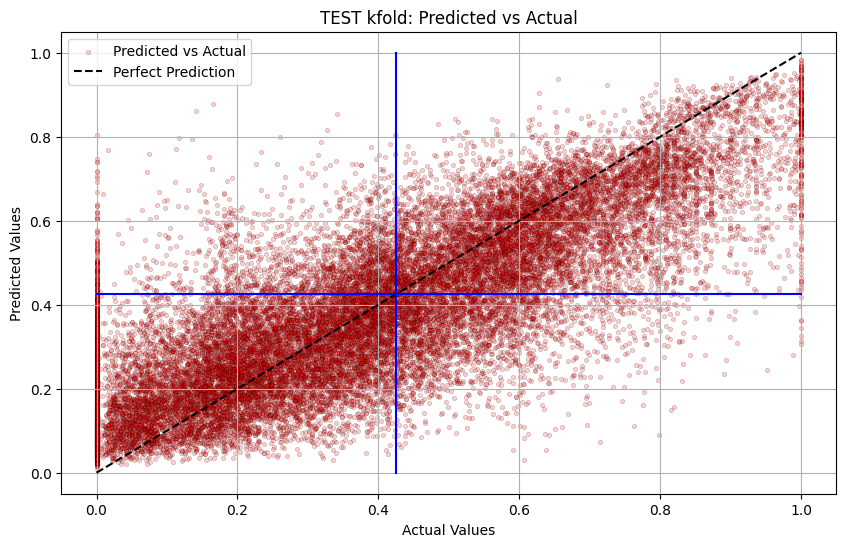

In [32]:
test_data = pd.DataFrame({
    'Predicted':avg_preds,
    'Actual': test_labels
})
plt.figure(figsize=(10, 6))
sns.scatterplot(x=test_data['Actual'], y=test_data['Predicted'], color='red', s=10, alpha=0.2, edgecolor='black', linewidth=0.5, label='Predicted vs Actual')
plt.plot([min(test_data['Actual']), max(test_data['Actual'])], [min(test_data['Actual']), max(test_data['Actual'])], color='black', linestyle='--', label='Perfect Prediction')
plt.plot([0.4256,0.4256],[0,1],color='blue',)
plt.plot([0,1],[0.4256,0.4256],color='blue')
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("TEST kfold: Predicted vs Actual")
plt.legend()
plt.grid(True)
plt.show()


Statistics for Test Labels (True Values):
        Test Labels
count  26857.000000
mean       0.380822
std        0.262244
min        0.000000
25%        0.168865
50%        0.369153
75%        0.578369
max        1.000000

Statistics for Test Predictions (Predicted Values):
       Test Predictions
count      26857.000000
mean           0.380544
std            0.207878
min            0.009797
25%            0.210120
50%            0.361380
75%            0.533300
max            0.982270

Statistics for K-Fold Residuals (Errors):
          Residuals
count  26857.000000
mean       0.000278
std        0.153108
min       -0.803478
25%       -0.090234
50%       -0.004912
75%        0.092553
max        0.709147


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


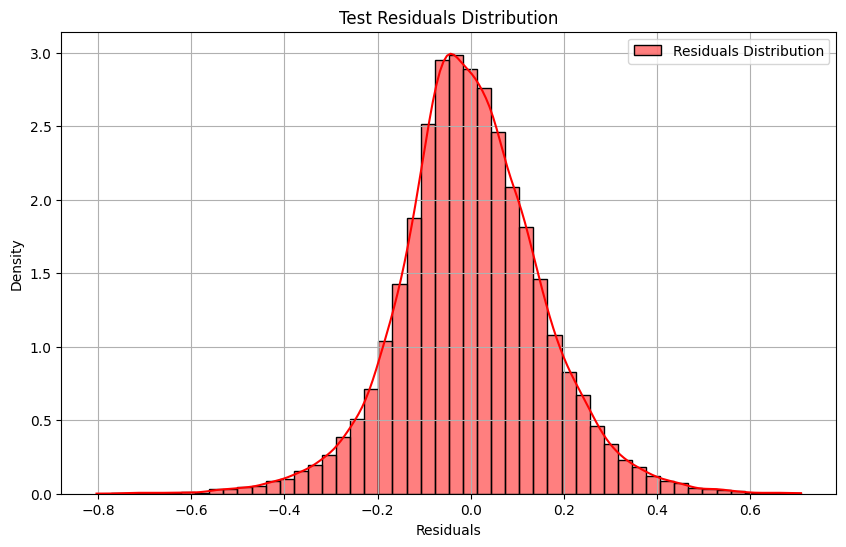

In [34]:
kfold_residuals = test_labels - avg_preds

# Create DataFrames
df_labels = pd.DataFrame(test_labels, columns=['Test Labels'])
df_preds = pd.DataFrame(avg_preds, columns=['Test Predictions'])
df_residuals = pd.DataFrame(kfold_residuals, columns=['Residuals'])

# Print statistics using .describe()
print("\nStatistics for Test Labels (True Values):")
print(df_labels.describe())

print("\nStatistics for Test Predictions (Predicted Values):")
print(df_preds.describe())

print("\nStatistics for K-Fold Residuals (Errors):")
print(df_residuals.describe())

# Plot residuals histogram
plt.figure(figsize=(10, 6))
sns.histplot(kfold_residuals, kde=True, color='red', bins=50, stat='density', label='Residuals Distribution')
plt.xlabel('Residuals')
plt.ylabel('Density')
plt.title('Test Residuals Distribution')
plt.legend()
plt.grid(True)
plt.show()


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


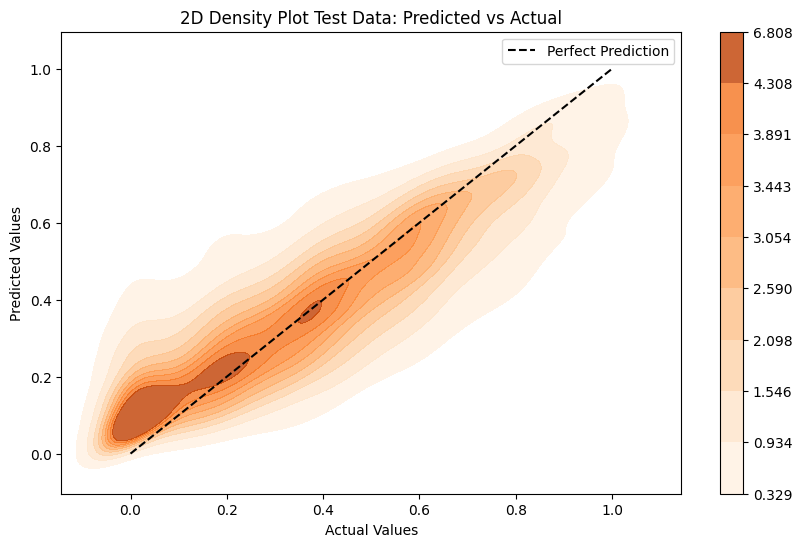

In [35]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


test_data = pd.DataFrame({
    'Predicted': avg_preds,
    'Actual': test_labels
})

plt.figure(figsize=(10, 6))
kde = sns.kdeplot(
    x=test_data['Actual'],
    y=test_data['Predicted'],
    cmap="Oranges",
    fill=True,
    levels=10,
    alpha=0.8,
    cbar=True
)

plt.plot([min(test_data['Actual']), max(test_data['Actual'])], [min(test_data['Actual']), max(test_data['Actual'])], color='black', linestyle='--', label='Perfect Prediction')
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("2D Density Plot Test Data: Predicted vs Actual")
plt.legend()
plt.show()
